In [50]:
import torch
import torchvision
import torchvision.transforms.v2 as transforms
from torchinfo import summary

In [51]:
torch.__version__, torchvision.__version__

('2.1.0', '0.16.0')

In [52]:
from going_modular.module import data_loader, engine

In [53]:
basedir = "./"
train_dir = basedir + "data/pizza_steak_sushi/train"
test_dir = basedir + "data/pizza_steak_sushi/test"

In [54]:
manual_transforms = transforms.Compose([
    # Create a transforms pipeline manually (required for torchvision < 0.13)
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToImage(), 
    transforms.ToDtype(torch.float32, scale=True), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each 
])

In [55]:
train_dataloader, test_dataloader, classnames = data_loader.create_dataloaders(train_dir=train_dir, test_dir=test_dir,transform=manual_transforms, batch_size=32)

In [56]:
X, y = next(iter(train_dataloader))
X.shape, y.shape, classnames

(torch.Size([32, 3, 224, 224]), torch.Size([32]), ['pizza', 'steak', 'sushi'])

In [57]:
# Automatic Transforms
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT = best performing weights
auto_transforms = weights.transforms()

In [58]:
train_dataloader, test_dataloader, classnames = data_loader.create_dataloaders(train_dir=train_dir, test_dir=test_dir,transform=auto_transforms, batch_size=32)

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [60]:
weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b1(weights=weights)

In [61]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [62]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [63]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

# Print the summary to see if all the param layers are freezed...

In [64]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(classnames)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True))

In [65]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [66]:
NUM_EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.001
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [67]:
from timeit import default_timer as timer 

In [68]:
start_time = timer()

# Start training with help from engine.py
results = engine.train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=NUM_EPOCHS,
             device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0684 | train_acc: 0.5273 | test_loss: 1.0089 | test_acc: 0.7348
Epoch: 2 | train_loss: 0.9726 | train_acc: 0.6094 | test_loss: 0.9084 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.8618 | train_acc: 0.8789 | test_loss: 0.8515 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.8430 | train_acc: 0.7422 | test_loss: 0.7697 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.7922 | train_acc: 0.7773 | test_loss: 0.7251 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.7339 | train_acc: 0.7969 | test_loss: 0.7167 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.6747 | train_acc: 0.8125 | test_loss: 0.6584 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.6466 | train_acc: 0.9297 | test_loss: 0.6133 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.6305 | train_acc: 0.8320 | test_loss: 0.5966 | test_acc: 0.9489
Epoch: 10 | train_loss: 0.5579 | train_acc: 0.9297 | test_loss: 0.5733 | test_acc: 0.9384
[INFO] Total training time: 28.196 seconds


In [69]:
from scripts.helper_functions import *

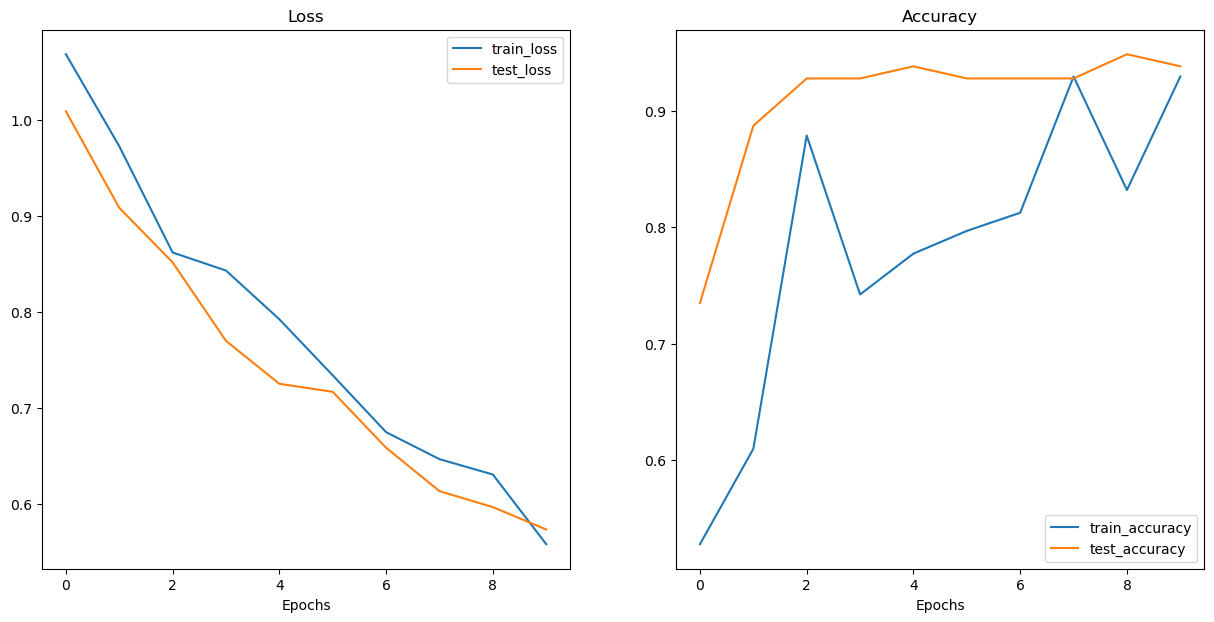

In [70]:
plot_loss_curves(results)


### Make predictions

In [73]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

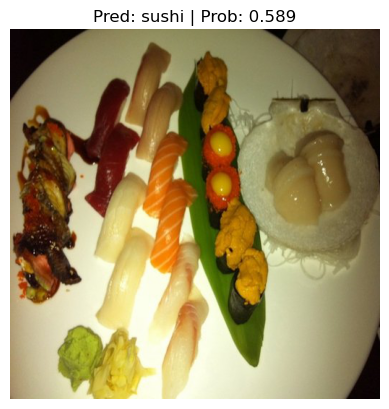

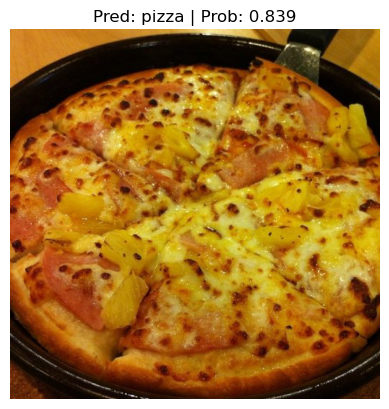

In [76]:
import random
num_images_to_plot = 2
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=classnames,
                        transform=weights.transforms(),
                        image_size=(224, 224))